<a href="https://colab.research.google.com/github/DeepInsider/playground-data/blob/master/docs/articles/tf2_keras_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Digital Advantage - Deep Insider.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 「回帰問題（全1回）」 ― 連載『TensorFlow 2.0＋Keras（ tf.keras）入門』のノートブック（3）

<table valign="middle">
  <td>
    <a target="_blank" href="https://www.atmarkit.co.jp/ait/subtop/features/di/tf2keras_index.html"> <img src="https://re.deepinsider.jp/img/ml-logo/manabu.svg"/>Deep Insiderで記事を読む</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/DeepInsider/playground-data/blob/master/docs/articles/tf2_keras_regression.ipynb"> <img src="https://re.deepinsider.jp/img/ml-logo/gcolab.svg" />Google Colabで実行する</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/DeepInsider/playground-data/blob/master/docs/articles/tf2_keras_regression.ipynb"> <img src="https://re.deepinsider.jp/img/ml-logo/github.svg" />GitHubでソースコードを見る</a>
  </td>
</table>

※上から順に実行してください。上のコードで実行したものを再利用しているところがあるため、すべて実行しないとエラーになるコードがあります。  
　すべてのコードを一括実行したい場合は、メニューバーから［ランタイム］－［すべてのセルを実行］をクリックしてください。

※「Python 3」を利用してください。  
　Python 3を利用するには、メニューバーから［ランタイム］－［ランタイムのタイプを変更］を選択すると表示される［ノートブックの設定］ダイアログの、［ランタイムのタイプ］欄で「Python 3」に選択し、その右下にある［保存］ボタンをクリックしてください。

# 第7回　回帰問題をディープラーニング（基本のDNN）で解こう

## ■本稿の目的と方針

ディープラーニングの基本形である「DNN（ディープニューラルネットワーク」をTensorFlow 2.xで実装する方法を示す。これにより、連載第1回～第3回ですでに身に付けたニューラルネットワーク＆ディープラーニングの知識だけでも、さまざまな機械学習が行えることを確認する。

- 前提知識は、基本的なニューラルネットワークを組めること。具体的には『[TensorFlow 2＋Keras（tf.keras）入門 - ＠IT](https://www.atmarkit.co.jp/ait/subtop/features/di/tf2keras_index.html)』の第1回～第6回の知識レベルが必要
- 今回の課題： 「マルチガウシアン」座標点データセット（後述）の推論を、第1回～第3回のDNN知識および、第4回～第6回の書き方の知識だけで解決してみよう
- 第1回～第3回は、これまでのSequentialモデルではなく、サブクラスモデル（Subclassing API）で実装する（学習／訓練は、カスタムループではなく、簡単に利用できる`compile()`＆`fit()`メソッドを利用する）

## ■本稿で説明する大まかな流れ

- （0）本ノートブックを実行するための事前準備
- （1）データの準備
- （2）モデルの定義
- （3）学習／最適化（オプティマイザー）
- （4）評価／精度検証
- （5）推論／未知データによるテスト

## ■（0）本ノートブックを実行するための事前準備

In [0]:
# Google Colabで最新の2.xを使う場合、2.xに切り替える（Colab専用）
%tensorflow_version 2.x

### ●前提条件

### 【チェック】Pythonバージョン（※3系を使うこと）
Colabにインストール済みのものを使う。もし2系になっている場合は、メニューバーの［ランタイム］－［ランタイムのタイプを変更］をクリックして切り替えてほしい。

In [21]:
import sys
print('Python', sys.version)
# Python 3.6.9 (default, Apr 18 2020, 01:56:04)   …… などと表示される

Python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


### 【チェック】TensorFlowバージョン（※2系を使うこと）
基本的にはColabにインストール済みのものを使う。もし2系になっている場合は、リスト4-0を実行してバージョン2.0を使う。

In [22]:
import tensorflow as tf
print('TensorFlow', tf.__version__)
# TensorFlow 2.2.0 ……などと表示される

TensorFlow 2.2.0


### リスト0-1　［オプション］ライブラリ「TensorFlow」最新バージョンのインストール

In [23]:
# Google Colabで最新の2.xを使う場合（Colab専用）
%tensorflow_version 2.x

# 最新バージョンにアップグレードする場合
!pip install --upgrade tensorflow

# バージョンを明示してアップグレードする場合
#!pip install --upgrade tensorflow===2.1.0

# 最新バージョンをインストールする場合
#!pip install tensorflow

# バージョンを明示してインストールする場合
#!pip install tensorflow===2.1.0

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


### ［オプション］【チェック】TensorFlowバージョン（※インストール後の確認）
バージョン2.xになっているか再度チェックする。

In [24]:
import tensorflow as tf
print('TensorFlow', tf.__version__)
# TensorFlow 2.2.0 ……などと表示される

TensorFlow 2.2.0


## ■（1）データの準備


「[第1回　初めてのニューラルネットワーク実装、まずは準備をしよう ― 仕組み理解×初実装（前編）：TensorFlow 2＋Keras（tf.keras）入門 - ＠IT](https://www.atmarkit.co.jp/ait/articles/1909/19/news026.html)」の記事と同じように、シンプルな座標点データを生成して使う。具体的には「マルチガウシアン」の座標点データセットとして「[playground-data · PyPI](https://pypi.org/project/playground-data/)」を使用する。playground-dataパッケージの使い方は、前述の記事を参照してほしい。

なお、座標点データは、「[ニューラルネットワーク Playground - Deep Insider](https://deepinsider.github.io/playground/)」（以下、Playground）と同じ生成仕様となっている。

![「マルチガウシアン」座標点データセットの例](https://image.itmedia.co.jp/ait/articles/1909/19/l_di-02-4.gif)

#### リスト1-1　ライブラリ「playground-data」のインストール

In [25]:
# 座標点データを生成するライブラリのインストール
!pip install playground-data

### リスト1-2　「マルチガウシアン」座標点データの生成

In [26]:
# playground-dataライブラリのplygdataパッケージを「pg」という別名でインポート
import plygdata as pg

# 設定値を定数として定義
PROBLEM_DATA_TYPE = pg.DatasetType.RegressGaussian # 問題種別：「回帰（Regress）」、データ種別：「マルチガウシアン（Gaussian）」を選択
TRAINING_DATA_RATIO = 0.5  # データの何％を訓練【Training】用に？ (残りは精度検証【Validation】用) ： 50％
DATA_NOISE = 0.0           # ノイズ： 0％

# 定義済みの定数を引数に指定して、データを生成する
data_list = pg.generate_data(PROBLEM_DATA_TYPE, DATA_NOISE)

# データを「訓練用」と「精度検証用」を指定の比率で分割し、さらにそれぞれを「データ（X）」と「教師ラベル（y）」に分ける
X_train, y_train, X_valid, y_valid = pg.split_data(data_list, training_size=TRAINING_DATA_RATIO)

# データ分割後の各変数の内容例として、それぞれ5件ずつ出力（※出力内容は実行ごとに異なる）
print('X_train:'); print(X_train[:5]) # [[-2.38054557 -4.32394847], ……]
print('y_train:'); print(y_train[:5]) # [[ 0.        ], [-0.2487588 ], ……]
print('X_valid:'); print(X_valid[:5]) # [[-0.02550047 -0.53284492], ……]
print('y_valid:'); print(y_valid[:5]) # [[ 0.01633982], [ 0.        ], ……]

X_train:
[[ 2.73018514 -1.77319105]
 [-4.91082808 -1.11460616]
 [ 4.30479501 -4.3492769 ]
 [ 3.436885   -2.92442219]
 [-3.37017952  2.06764774]]
y_train:
[[-0.26844668]
 [-0.17100605]
 [-0.06288674]
 [-0.64742636]
 [ 0.61803066]]
X_valid:
[[-1.27859951  3.16452691]
 [-1.57874977 -5.55888729]
 [ 1.74136431  3.38264891]
 [-1.83325343 -3.50671952]
 [ 4.66343268 -4.56156968]]
y_valid:
[[-0.27951185]
 [ 0.        ]
 [-0.02385724]
 [ 0.        ]
 [ 0.        ]]


### リスト1-3　入力データの描画

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f698007a588>)

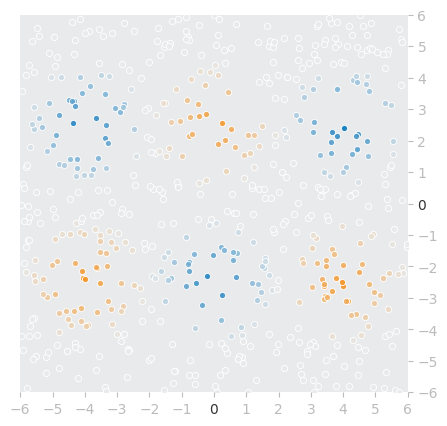

In [27]:
pg.plot_points_with_playground_style(X_train, y_train)

このコードのポイント：

- 「マルチガウシアン」座標点データセットは、前述したPyPIパッケージ「playground-data」（別名として`pg`を定義）の[`pg.generate_data()`関数](https://github.com/DeepInsider/playground-data/blob/master/plygdata/dataset.py#L101)で取得できる
- `generate_data(PROBLEM_DATA_TYPE, DATA_NOISE)`関数の、第1引数には[`pg.DatasetType`クラス変数](https://github.com/DeepInsider/playground-data/blob/master/plygdata/state.py#L36)で問題種別を、第2引数にはfloat値で座標点生成時のノイズを指定する。戻り値は［X座標、Y座標、正解ラベル］が1200件（回帰の場合。分類の場合は500件）ほど格納されたPython多次元リストとなっている
- この座標点データを訓練用と精度検証用に分割したい場合は、[`pg.split_data(data_list, training_size=TRAINING_DATA_RATIO)`関数](https://github.com/DeepInsider/playground-data/blob/master/plygdata/datahelper.py#L34)を使えばよい。第1引数には先ほど生成したPython多次元リストを、引数`training_size`にはfloat値で訓練用データの割合を指定すればよい。
- 座標点データのサンプル出力では、グラフ描画用の`pg.plot_points_with_playground_style(X_train, y_train)`関数を利用している。第1引数に訓練用データの入力データ（＝特徴量）を、第2引数には訓練用データのラベルを指定する。

### ●バッチデータの作成について

今回は、tf.kerasの基本である`compile()`＆`fit()`メソッドを使用する。その場合、`fit()`メソッドがデータをミニバッチ学習用に自動分割したり、トレーニング時にエポックごとのループ処理を自動的に行ってくれたりするため、手動でバッチデータ化する必要がない。そのため、本ノートブックでは「バッチデータの作成」は割愛する。

なお、エキスパート向けである「`tf.GradientTape`クラスを使ったカスタムループ」を実装する場合は、バッチデータを作成する必要がある。その方法は、「[第5回　お勧めの、TensorFlow 2.0最新の書き方入門（エキスパート向け） (2ページ目)](https://www.atmarkit.co.jp/ait/articles/2003/10/news016_2.html)」で説明している。

## ■（2）モデルの定義

既に何度か説明しているが、以下の通りで進めていく。
- `tf.keras.Model`クラスを**サブクラス化**してモデルを定義する（**初中級者以上にお勧め**）
- tf.kerasの基本である`compile()`＆`fit()`メソッドを使用する（今回はカスタムループの実装は不要なため）

### ●ディープニューラルネットワークのモデル設計
- 入力の数（`INPUT_FEATURES`）は、$X_1$と$X_2$で**2つ**
- 隠れ層のレイヤー数は、**2つ**
  - 隠れ層にある1つ目のニューロンの数（`LAYER1_NEURONS`）は、**4つ**
  - 隠れ層にある2つ目のニューロンの数（`LAYER2_NEURONS`）は、**3つ**
- 出力層にあるニューロンの数（`OUTPUT_RESULTS`）は、**1つ**

### リスト2-1　モデルの定義

In [0]:
import tensorflow as tf  # ライブラリ「TensorFlow」のtensorflowパッケージをインポート
from tensorflow.keras import layers       # 「レイヤーズ」モジュールのインポート
from IPython.display import Image


# 定数（モデル定義時に必要となるもの）
INPUT_FEATURES = 2    # 入力（特徴）の数： 2（＝X座標とY座標）
LAYER1_NEURONS = 4    # ニューロンの数： 4
LAYER2_NEURONS = 3    # ニューロンの数： 3
OUTPUT_RESULTS = 1    # 出力結果の数： 1（＝結果は基本的に「-1.0」～「1.0」の数値）

# 変数（モデル定義時に必要となるもの）
activation1 = layers.Activation('tanh' # 活性化関数（隠れ層用）： tanh関数（変更可能）
    , name='activation1'               # 名前付け
    )
activation2 = layers.Activation('tanh' # 活性化関数（隠れ層用）： tanh関数（変更可能）
    , name='activation2'               
    )
acti_out = layers.Activation('linear'  # 活性化関数（出力層用）： そのまま出力（固定）
    , name='acti_out'                  
    )

# tf.keras.Modelによるモデルの定義
class NeuralNetwork(tf.keras.Model):

  # ### レイヤーを定義 ###
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    # 入力層は定義「不要」。実際の入力によって決まるので

    # 隠れ層：1つ目のレイヤー（layer）
    self.layer1 = layers.Dense(    # 全結合層（線形変換）
      #input_shape=(INPUT_FEATURES,),  # 入力層（定義不要）
      LAYER1_NEURONS,              # 次のレイヤーへの出力ユニット数
      name='layer1')

    # 隠れ層：2つ目のレイヤー（layer）
    self.layer2 = layers.Dense(    # 全結合層
      LAYER2_NEURONS,              # 次のレイヤーへの出力ユニット数
      name='layer2')

    # 出力層
    self.layer_out = layers.Dense( # 全結合層
      OUTPUT_RESULTS,              # 出力結果への出力ユニット数
      name='layer_out')

  # ### フォワードパスを定義 ###
  def call(self, inputs, training=None):   # 入力と、訓練／評価モード
    # 「出力＝活性化関数（第n層（入力））」の形式で記述
    x1 = activation1(self.layer1(inputs))  # 活性化関数は変数として定義
    x2 = activation2(self.layer2(x1))      # 同上
    outputs = acti_out(self.layer_out(x2)) # そのまま出力（＝「恒等関数」）
    return outputs

  # モデル内容の出力を行う独自メソッド
  def get_functional_model(self):
    x = layers.Input(shape=(INPUT_FEATURES,), name='input_features')
    static_model = tf.keras.Model(inputs=[x], outputs=self.call(x)) 
    return static_model

このコードのポイント：
- このコードは、「[第5回　お勧めの、TensorFlow 2.0最新の書き方入門（エキスパート向け） (1/2)：TensorFlow 2＋Keras（tf.keras）入門 - ＠IT](https://www.atmarkit.co.jp/ait/articles/2003/10/news016.html)」で説明したものとほぼ同じ書き方（サブクラス型）である
- ニューラルネットワークモデルの定義方法は、「[第2回　ニューラルネットワーク最速入門 ― 仕組み理解×初実装（中編）：TensorFlow 2＋Keras（tf.keras）入門 - ＠IT](https://www.atmarkit.co.jp/ait/articles/1910/17/news026.html)」で説明した通り
- 隠れ層の活性化関数は、今回も[Tanh関数](https://www.atmarkit.co.jp/ait/articles/2003/19/news015.html)を使用した。これはオレンジ色（＝-1.0）～青色（＝1.0）の範囲で数値を出力できるためである。より一般的な[ReLU関数](https://www.atmarkit.co.jp/ait/articles/2003/11/news016.html)（`"relu"`という文字列を指定）を使ってもよい
- 出力層の活性化関数は、今回は[線形関数（＝恒等関数）](https://www.atmarkit.co.jp/ait/articles/2004/01/news045.html)を指定している。この関数はそのまま出力するという意味なので、活性化関数自体は使わなくても同じ意味となる
- `get_functional_model()`メソッドは、次のリスト2-2でモデル内容を描画するために用意した独自の関数である（本来の処理には不要）

### リスト2-2　モデル内容（テキスト）の確認

In [29]:
# モデル（NeuralNetworkクラス）のインスタンス化
model = NeuralNetwork()
s_model = model.get_functional_model()
s_model.summary() # モデルの内容を出力

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  [(None, 2)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 4)                 12        
_________________________________________________________________
activation1 (Activation)     (None, 4)                 0         
_________________________________________________________________
layer2 (Dense)               (None, 3)                 15        
_________________________________________________________________
activation2 (Activation)     (None, 3)                 0         
_________________________________________________________________
layer_out (Dense)            (None, 1)                 4         
_________________________________________________________________
acti_out (Activation)        (None, 1)                 0   

### リスト2-3　モデル内容（図）の確認

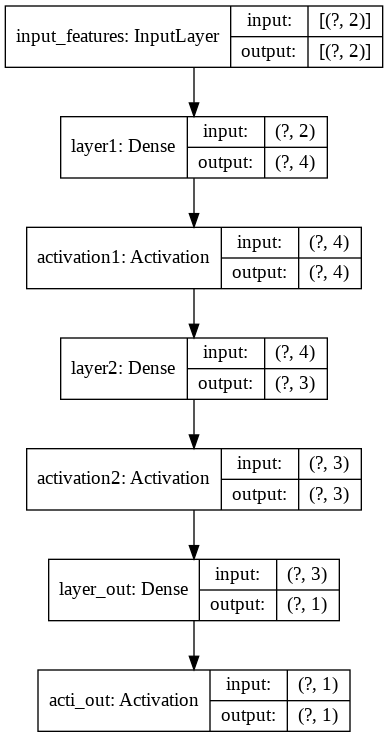

In [30]:
# Plot model graph
filename = 'model.png';
tf.keras.utils.plot_model(s_model, show_shapes=True, show_layer_names=True, to_file=filename)
from IPython.display import Image
Image(retina=False, filename=filename)

## ■（3）学習／最適化（オプティマイザー）

これまでに学んで来た内容とほぼ変わらないため、説明を割愛する。

### リスト3-1　学習方法（損失関数／最適化／学習率）の定義

In [0]:
# 定数（学習方法設計時に必要となる数値）
LOSS = 'mean_squared_error'  # 損失関数：平均二乗誤差
OPTIMIZER = tf.keras.optimizers.SGD  # 最適化：確率的勾配降下法
LEARNING_RATE = 0.01     # 学習率： 0.01

# 学習方法を定義する
model.compile(optimizer=OPTIMIZER(learning_rate=LEARNING_RATE),
              loss=LOSS,
              metrics=[])  # 精度（分類では正解率。回帰では損失）

### リスト3-2　トレーニング（ミニバッチ学習）

In [32]:
# 定数（ミニバッチ学習時に必要となるもの）
BATCH_SIZE = 15   # バッチサイズ： 15（選択肢は「1」～「30」）
EPOCHS = 300     # エポック数： 300

# 早期終了（今回はコメントアウト）
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 学習する
hist = model.fit(x=X_train,                          # 訓練用データ
                 y=y_train,                          # 訓練用ラベル
                 validation_data=(X_valid, y_valid), # 精度検証用
                 batch_size=BATCH_SIZE,              # バッチサイズ
                 epochs=EPOCHS,                      # エポック数
                 verbose=1,                          # 実行状況表示
                 callbacks=[])                       # コールバック（早期終了しない場合）
                 #callbacks=[es])                    # コールバック（早期終了する場合）

Epoch 1/300
40/40 [==============================] - 0s 4ms/step - loss: 0.1257 - val_loss: 0.0676
Epoch 2/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0589
Epoch 3/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0562
Epoch 4/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0549
Epoch 5/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0533
Epoch 6/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0525
Epoch 7/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0516
Epoch 8/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0511
Epoch 9/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0509
Epoch 10/300
40/40 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0496
Epoch 11/

## ■（4）評価／精度検証

これも、これまでの記事とほぼ同じ内容なので説明を割愛する。

### リスト4-1　損失値の推移グラフ描画

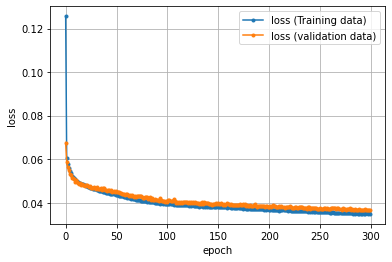

In [33]:
import matplotlib.pyplot as plt

# 学習結果（損失）のグラフを描画
train_loss = hist.history['loss']
valid_loss = hist.history['val_loss']
epochs = len(train_loss)
plt.plot(range(epochs), train_loss, marker='.', label='loss (Training data)')
plt.plot(range(epochs), valid_loss, marker='.', label='loss (validation data)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

実行結果のポイント：
- 損失（loss）は訓練データでも精度検証データでも同様に下がっている

## ■（5）推論／未知データによるテスト

### リスト5-1　入力データの描画（リスト1-3の再掲）

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f697ed7df60>)

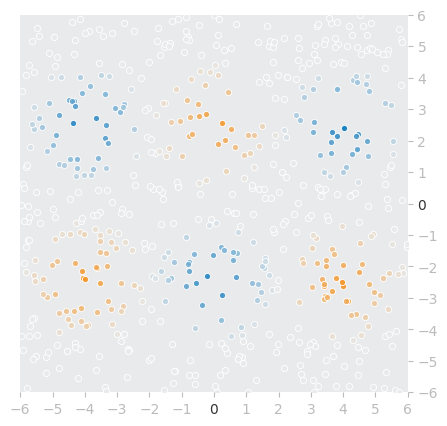

In [34]:
pg.plot_points_with_playground_style(X_train, y_train)

このコードのポイント：
- 「playground-data」PyPIパッケージには、入力データを描画するための`plot_points_with_playground_style()`関数が用意されており、上記のコードのようにして使える

### リスト5-2　未知データによるテスト（推論）

上のグラフで青い部分の座標を指定して推論してみよう。例えば次のコードでは、(0.0, -3.0)の座標の結果値を推論してみている。

In [35]:
# 推論（予測）する
model.predict([[0.0, -3.0]])
# array([[0.19012895]], dtype=float32) ……などと出力される

array([[0.19869453]], dtype=float32)

実行結果のポイント：
- 「0.19012895」と出力され、やや青色になっている

### リスト5-3　学習結果の描画

全ての座標点でこのようなこの出力結果をプロットすると、（分類問題における決定境界のような）グラフを描画できる。「playground-data」PyPIパッケージには、学習結果（決定境界）を描画するための`draw_decision_boundary()`関数が用意されており、次のコードのようにして使える。

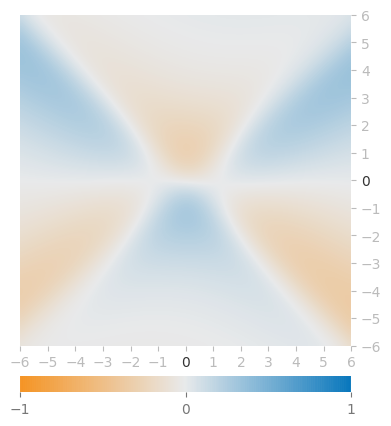

In [36]:
# 決定境界のグラフを描画する
fig = pg.get_playground_figure()
ax = pg.get_playground_axes(fig)
pg.draw_decision_boundary(fig, ax, trained_model=model)

# お疲れさまでした。第7回は修了です。